In [1]:
# training visualization
# %load_ext tensorboard

import os
import math
import pickle
import random
from functools import partial
from typing import Dict, Optional, Callable

# for math operations
import gdown
import numpy as np
from tqdm import tqdm

# ML packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

# training visualization
# from tqdm import trange
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

# impelementations
from autoencoders import ResNetAutoEncoder
from prototypical_network import ClassificationDataset, PrototypicalNetwork, Convnet
from autoencoder_prototypical import PrototypicalAutoencoderNetwork, ArcAutoencoder, ArcLayer, ArcMarginProduct, AddMarginProduct, SphereProduct

state = 42
torch.manual_seed(state)
torch.cuda.manual_seed(state)
np.random.seed(state)
random.seed(state)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

/home/woreom/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bird_dataset(path: str= "../../datasets/birds/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96)),
         # transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    
    return dataset

def check_folder_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    label_mapping = {y: x for x, y in dataset.class_to_idx.items()}

    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, (img, label) in enumerate(dataset):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        plt.title(label_mapping[label], fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")
        
def download_from_gdrive(_id: str, output: str) -> None:
    gdown.download(id= _id, output= output)

def get_mini_magenet(root: str, mode: str, transform: Optional[Callable] = None, download: bool= False,
                     target_transform: Optional[Callable] = None) -> torch.utils.data.Dataset:
    """Mini ImageNet Dataset Loader for torch"""
    
    gdrive_id = {"test":'1wpmY-hmiJUUlRBkO9ZDCXAcIpHEFdOhD', "train":'1I3itTXpXxGV68olxM5roceUMG8itH9Xj',
                 "val":'1KY5e491bkLFqJDp0-UWou3463Mo8AOco'}
    
    pickle_file = os.path.join(root, f'mini-imagenet_{mode}.pkl')
    
    # download pkl file
    if not os.path.exists(pickle_file) and download:
        print(f"Downloading mini-imagenet_{model} at {pickle_file}")
        download_from_gdrive(_id=MiniImagenet.gdrive_id[mode], output=pickle_file)
        
    # open pkl file
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    
    # create X and y
    X = torch.from_numpy(data["image_data"]).permute(0, 3, 1, 2).float()
    y = np.ones(X.shape[0])

    # dict of indexes to np.array
    for (i, key) in enumerate(data['class_dict'].keys()):
        for idx in data['class_dict'][key]:
            y[idx] = i

    return ClassificationDataset(X= X, y= y, transform= transform,
                                 target_transform= target_transform)

def check_MetaDataset_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    sample = dataset.sample()
    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, img in enumerate(sample[0]):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        plt.title(sample[1][i].numpy(), fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")

image.shape: torch.Size([3, 96, 96])


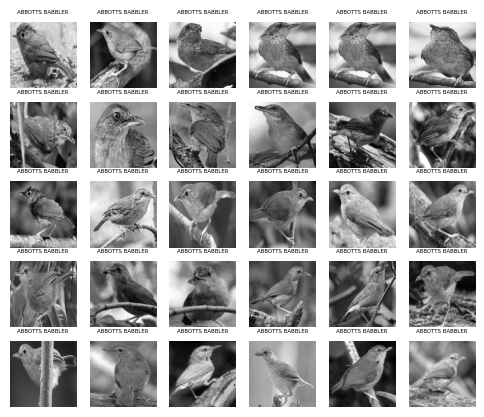

In [3]:
dataset = get_bird_dataset(path= "../../datasets/birds/", mode= "train")
check_folder_loader(dataset= dataset, grid_split=6, num_img=30)

image.shape: torch.Size([3, 96, 96])


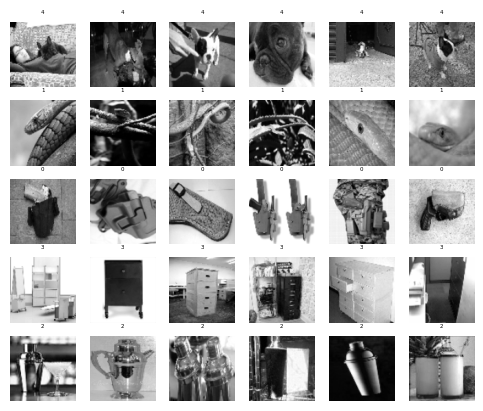

In [4]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    ])

dataset = get_mini_magenet(mode= 'train', root="../../datasets/mini_imagenet_temp/",
                      transform=transform, target_transform=None, download=False)   

mode_dataset = l2l.data.MetaDataset(dataset)
mode_transforms = [
    NWays(mode_dataset, 5),
    KShots(mode_dataset, 1+5),
    LoadData(mode_dataset),
    RemapLabels(mode_dataset),
]

mode_tasks = l2l.data.TaskDataset(mode_dataset, task_transforms=mode_transforms,
                                  num_tasks= max(dataset.y))

mode_loader = DataLoader(mode_tasks, pin_memory=True, shuffle=True, )
check_MetaDataset_loader(dataset= mode_loader.dataset, grid_split= 6, num_img= 50)

In [5]:
autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
                                batch_size=128, eval_step=5)

_input = torch.randn((5,3,96,96))

print(f"encoder output: {_input.shape}")

output = autoencoder.encoder(_input)

print(f"encoder output: {output.shape}")

a = ArcLayer(out_features=5)
output = torch.flatten(output, start_dim=1)
a.fit(output, torch.arange(0,5))
output = a(output)

print(f"arcface output: {output.shape}")
output[0]

encoder output: torch.Size([5, 3, 96, 96])
encoder output: torch.Size([5, 512, 3, 3])
arcface output: torch.Size([5, 5])


tensor([ 0.3802, -0.2568, -0.2338, -0.2411, -0.2901],
       grad_fn=<SelectBackward0>)

# Prototypical Network With Autoencoders

In [6]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    model = PrototypicalAutoencoderNetwork(autoencoder= autoencoder,)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 100, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)


 ================== New Test ================== 



Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 18.54episode/s, acc=(0.386, 0.008), loss=(1.4106, 0.0434), mode=test]


best acc: (0.386, 0.0079), loss: (1.411, 0.0434)


Epoch 2: 100%|██████████| 100/100 [00:05<00:00, 19.35episode/s, acc=(0.400, 0.010), loss=(1.4825, 0.0350), mode=test]


best acc: (0.4, 0.0101), loss: (1.483, 0.035)


Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 18.75episode/s, acc=(0.410, 0.009), loss=(1.4126, 0.0342), mode=test]


best acc: (0.41, 0.009), loss: (1.413, 0.0342)


Epoch 6: 100%|██████████| 100/100 [00:05<00:00, 18.92episode/s, acc=(0.411, 0.007), loss=(1.3475, 0.0149), mode=test]


best acc: (0.411, 0.0069), loss: (1.347, 0.0149)


Epoch 8: 100%|██████████| 100/100 [00:05<00:00, 18.98episode/s, acc=(0.472, 0.011), loss=(1.3470, 0.0231), mode=test]


best acc: (0.472, 0.0107), loss: (1.347, 0.0231)


Epoch 13: 100%|██████████| 100/100 [00:05<00:00, 19.49episode/s, acc=(0.485, 0.014), loss=(1.3092, 0.0290), mode=test]


best acc: (0.485, 0.0137), loss: (1.309, 0.029)


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 19.19episode/s, acc=(0.489, 0.011), loss=(1.2742, 0.0156), mode=test]


best acc: (0.489, 0.0107), loss: (1.274, 0.0156)


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 19.41episode/s, acc=(0.492, 0.005), loss=(1.2361, 0.0316), mode=test]


best acc: (0.492, 0.0054), loss: (1.236, 0.0316)


Epoch 23: 100%|██████████| 100/100 [00:05<00:00, 19.31episode/s, acc=(0.503, 0.012), loss=(1.2693, 0.0397), mode=test]


best acc: (0.503, 0.0118), loss: (1.269, 0.0397)


Epoch 25: 100%|██████████| 100/100 [00:05<00:00, 19.21episode/s, acc=(0.513, 0.009), loss=(1.2110, 0.0401), mode=test]


best acc: (0.513, 0.0091), loss: (1.211, 0.0401)


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 19.27episode/s, acc=(0.542, 0.008), loss=(1.2496, 0.0243), mode=test]


best acc: (0.542, 0.0085), loss: (1.25, 0.0243)


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 19.22episode/s, acc=(0.562, 0.006), loss=(1.1627, 0.0245), mode=test]


best acc: (0.562, 0.0062), loss: (1.163, 0.0245)


100%|██████████| 100/100 [00:05<00:00, 19.45episode/s, acc=(0.458, 0.008), loss=(1.4088, 0.0175), mode=test]


best acc: (0.562, 0.0062), loss: (1.163, 0.0245)

 ================== New Test ================== 



Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 19.04episode/s, acc=(0.436, 0.009), loss=(1.4046, 0.0333), mode=test]


best acc: (0.436, 0.0094), loss: (1.405, 0.0333)


Epoch 2: 100%|██████████| 100/100 [00:05<00:00, 19.41episode/s, acc=(0.460, 0.015), loss=(1.3162, 0.0237), mode=test]


best acc: (0.46, 0.0154), loss: (1.316, 0.0237)


Epoch 3: 100%|██████████| 100/100 [00:05<00:00, 19.18episode/s, acc=(0.504, 0.019), loss=(1.3497, 0.0245), mode=test]


best acc: (0.504, 0.0192), loss: (1.35, 0.0245)


Epoch 12: 100%|██████████| 100/100 [00:05<00:00, 19.26episode/s, acc=(0.514, 0.005), loss=(1.2308, 0.0162), mode=test]


best acc: (0.514, 0.0051), loss: (1.231, 0.0162)


Epoch 13: 100%|██████████| 100/100 [00:05<00:00, 19.33episode/s, acc=(0.529, 0.004), loss=(1.1661, 0.0105), mode=test]


best acc: (0.529, 0.004), loss: (1.166, 0.0105)


Epoch 14: 100%|██████████| 100/100 [00:05<00:00, 19.30episode/s, acc=(0.540, 0.008), loss=(1.1825, 0.0243), mode=test]


best acc: (0.54, 0.0083), loss: (1.183, 0.0243)


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 19.11episode/s, acc=(0.556, 0.004), loss=(1.1667, 0.0096), mode=test]


best acc: (0.556, 0.0043), loss: (1.167, 0.0096)


Epoch 21: 100%|██████████| 100/100 [00:05<00:00, 19.41episode/s, acc=(0.596, 0.006), loss=(1.0820, 0.0193), mode=test]


best acc: (0.596, 0.0065), loss: (1.082, 0.0193)


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 19.73episode/s, acc=(0.609, 0.007), loss=(1.0449, 0.0203), mode=test]


best acc: (0.609, 0.0072), loss: (1.045, 0.0203)


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 19.32episode/s, acc=(0.620, 0.007), loss=(0.9952, 0.0306), mode=test]


best acc: (0.62, 0.0067), loss: (0.995, 0.0306)


Epoch 45: 100%|██████████| 100/100 [00:05<00:00, 19.56episode/s, acc=(0.643, 0.006), loss=(0.9763, 0.0260), mode=test]


best acc: (0.643, 0.0064), loss: (0.976, 0.026)


100%|██████████| 100/100 [00:05<00:00, 19.50episode/s, acc=(0.492, 0.012), loss=(1.3581, 0.0283), mode=test]


best acc: (0.643, 0.0064), loss: (0.976, 0.026)

 ================== New Test ================== 



Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 18.94episode/s, acc=(0.342, 0.006), loss=(1.5189, 0.0137), mode=test]


best acc: (0.342, 0.0059), loss: (1.519, 0.0137)


Epoch 4: 100%|██████████| 100/100 [00:05<00:00, 19.60episode/s, acc=(0.349, 0.006), loss=(1.4485, 0.0148), mode=test]


best acc: (0.349, 0.0062), loss: (1.448, 0.0148)


Epoch 5: 100%|██████████| 100/100 [00:05<00:00, 19.26episode/s, acc=(0.379, 0.007), loss=(1.4405, 0.0114), mode=test]


best acc: (0.379, 0.0072), loss: (1.44, 0.0114)


Epoch 7: 100%|██████████| 100/100 [00:05<00:00, 19.12episode/s, acc=(0.393, 0.004), loss=(1.4475, 0.0074), mode=test]


best acc: (0.393, 0.0043), loss: (1.447, 0.0074)


Epoch 15: 100%|██████████| 100/100 [00:05<00:00, 19.06episode/s, acc=(0.414, 0.007), loss=(1.4217, 0.0167), mode=test]


best acc: (0.414, 0.0067), loss: (1.422, 0.0167)


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 19.02episode/s, acc=(0.427, 0.014), loss=(1.3761, 0.0152), mode=test]


best acc: (0.427, 0.0143), loss: (1.376, 0.0152)


Epoch 20: 100%|██████████| 100/100 [00:05<00:00, 19.52episode/s, acc=(0.436, 0.012), loss=(1.3973, 0.0208), mode=test]


best acc: (0.436, 0.0119), loss: (1.397, 0.0208)


Epoch 23: 100%|██████████| 100/100 [00:05<00:00, 18.91episode/s, acc=(0.448, 0.008), loss=(1.3760, 0.0172), mode=test]


best acc: (0.448, 0.0081), loss: (1.376, 0.0172)


Epoch 24: 100%|██████████| 100/100 [00:05<00:00, 19.10episode/s, acc=(0.491, 0.013), loss=(1.2943, 0.0202), mode=test]


best acc: (0.491, 0.0127), loss: (1.294, 0.0202)


Epoch 40: 100%|██████████| 100/100 [00:05<00:00, 18.74episode/s, acc=(0.504, 0.010), loss=(1.2758, 0.0179), mode=test]


best acc: (0.504, 0.01), loss: (1.276, 0.0179)


Epoch 51:  31%|███       | 31/100 [00:07<00:16,  4.13episode/s, acc=(0.575, 0.017), loss=(1.0938, 0.0618), mode=train]


KeyboardInterrupt: 

In [7]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    model = PrototypicalAutoencoderNetwork(autoencoder= autoencoder,)
    model.update = True

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 100, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 10, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)


 ================== New Test ================== 



Epoch 10: 100%|██████████| 100/100 [00:21<00:00,  4.68episode/s, acc=(0.430, 0.017), loss=(1.3461, 0.0494), mode=test]


best acc: (0.43, 0.017), loss: (1.346, 0.0494)


Epoch 20: 100%|██████████| 100/100 [00:21<00:00,  4.59episode/s, acc=(0.483, 0.012), loss=(1.2476, 0.0553), mode=test]


best acc: (0.483, 0.012), loss: (1.248, 0.0553)


Epoch 30: 100%|██████████| 100/100 [00:21<00:00,  4.68episode/s, acc=(0.498, 0.018), loss=(1.2510, 0.0889), mode=test]


best acc: (0.498, 0.0177), loss: (1.251, 0.0889)


Epoch 40: 100%|██████████| 100/100 [00:21<00:00,  4.67episode/s, acc=(0.552, 0.018), loss=(1.1703, 0.0868), mode=test]


best acc: (0.552, 0.0178), loss: (1.17, 0.0868)


Epoch 50: 100%|██████████| 100/100 [00:22<00:00,  4.47episode/s, acc=(0.556, 0.014), loss=(1.1672, 0.0580), mode=test]


best acc: (0.556, 0.0141), loss: (1.167, 0.058)


100%|██████████| 100/100 [00:21<00:00,  4.55episode/s, acc=(0.388, 0.009), loss=(1.5109, 0.0033), mode=test]


best acc: (0.556, 0.0141), loss: (1.167, 0.058)

 ================== New Test ================== 



Epoch 10: 100%|██████████| 100/100 [00:22<00:00,  4.42episode/s, acc=(0.443, 0.014), loss=(1.2885, 0.0407), mode=test]


best acc: (0.443, 0.014), loss: (1.289, 0.0407)


Epoch 20: 100%|██████████| 100/100 [00:21<00:00,  4.56episode/s, acc=(0.506, 0.018), loss=(1.1872, 0.0867), mode=test]


best acc: (0.506, 0.0184), loss: (1.187, 0.0867)


Epoch 30: 100%|██████████| 100/100 [00:22<00:00,  4.54episode/s, acc=(0.532, 0.026), loss=(1.1590, 0.1071), mode=test]


best acc: (0.532, 0.0258), loss: (1.159, 0.1071)


Epoch 50: 100%|██████████| 100/100 [00:21<00:00,  4.56episode/s, acc=(0.554, 0.017), loss=(1.0635, 0.0933), mode=test]


best acc: (0.554, 0.0168), loss: (1.064, 0.0933)


Epoch 60: 100%|██████████| 100/100 [00:21<00:00,  4.61episode/s, acc=(0.557, 0.023), loss=(1.1386, 0.0964), mode=test]


best acc: (0.557, 0.0227), loss: (1.139, 0.0964)


Epoch 70: 100%|██████████| 100/100 [00:21<00:00,  4.58episode/s, acc=(0.570, 0.021), loss=(1.1195, 0.0794), mode=test]


best acc: (0.57, 0.0205), loss: (1.12, 0.0794)


100%|██████████| 100/100 [00:21<00:00,  4.57episode/s, acc=(0.403, 0.008), loss=(1.4750, 0.0043), mode=test]


best acc: (0.57, 0.0205), loss: (1.12, 0.0794)

 ================== New Test ================== 



Epoch 10: 100%|██████████| 100/100 [00:21<00:00,  4.55episode/s, acc=(0.464, 0.006), loss=(1.2936, 0.0031), mode=test]


best acc: (0.464, 0.0057), loss: (1.294, 0.0031)


Epoch 20: 100%|██████████| 100/100 [00:23<00:00,  4.31episode/s, acc=(0.517, 0.004), loss=(1.2052, 0.0110), mode=test]


best acc: (0.517, 0.0037), loss: (1.205, 0.011)


Epoch 30: 100%|██████████| 100/100 [00:23<00:00,  4.34episode/s, acc=(0.531, 0.013), loss=(1.1706, 0.0284), mode=test]


best acc: (0.531, 0.0126), loss: (1.171, 0.0284)


Epoch 50: 100%|██████████| 100/100 [00:23<00:00,  4.33episode/s, acc=(0.552, 0.005), loss=(1.1214, 0.0142), mode=test]


best acc: (0.552, 0.0054), loss: (1.121, 0.0142)


100%|██████████| 100/100 [00:21<00:00,  4.56episode/s, acc=(0.402, 0.011), loss=(1.5068, 0.0106), mode=test]


best acc: (0.552, 0.0054), loss: (1.121, 0.0142)

 ================== New Test ================== 



Epoch 10: 100%|██████████| 100/100 [00:21<00:00,  4.56episode/s, acc=(0.380, 0.008), loss=(1.4663, 0.0351), mode=test]


best acc: (0.38, 0.0079), loss: (1.466, 0.0351)


Epoch 20: 100%|██████████| 100/100 [00:21<00:00,  4.60episode/s, acc=(0.452, 0.008), loss=(1.3403, 0.0247), mode=test]


best acc: (0.452, 0.0081), loss: (1.34, 0.0247)


Epoch 30: 100%|██████████| 100/100 [00:21<00:00,  4.64episode/s, acc=(0.506, 0.022), loss=(1.2490, 0.0612), mode=test]


best acc: (0.506, 0.0221), loss: (1.249, 0.0612)


Epoch 40: 100%|██████████| 100/100 [00:21<00:00,  4.65episode/s, acc=(0.517, 0.017), loss=(1.2250, 0.0531), mode=test]


best acc: (0.517, 0.0173), loss: (1.225, 0.0531)


Epoch 50: 100%|██████████| 100/100 [00:21<00:00,  4.63episode/s, acc=(0.528, 0.019), loss=(1.1646, 0.0313), mode=test]


best acc: (0.528, 0.0186), loss: (1.165, 0.0313)


100%|██████████| 100/100 [00:21<00:00,  4.67episode/s, acc=(0.419, 0.009), loss=(1.4813, 0.0049), mode=test]


best acc: (0.528, 0.0186), loss: (1.165, 0.0313)

 ================== New Test ================== 



Epoch 10: 100%|██████████| 100/100 [00:22<00:00,  4.51episode/s, acc=(0.412, 0.016), loss=(1.3859, 0.0320), mode=test]


best acc: (0.412, 0.016), loss: (1.386, 0.032)


Epoch 20:  52%|█████▏    | 52/100 [00:12<00:11,  4.24episode/s, acc=(0.555, 0.015), loss=(1.1502, 0.0493), mode=train]


KeyboardInterrupt: 

# Relation Network with ArcFace Last Layer

In [6]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    fc = partial(ArcLayer, s=30.0, m=0.5,)
    model = ArcAutoencoder(autoencoder= autoencoder, fc= fc)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 100, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)


 ================== New Test ================== 



Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.50episode/s, acc=(0.327, 0.007), loss=(1.5419, 0.0027), mode=test]


best acc: (0.327, 0.0074), loss: (1.542, 0.0027)


Epoch 4: 100%|██████████| 100/100 [00:07<00:00, 12.55episode/s, acc=(0.354, 0.009), loss=(1.5295, 0.0029), mode=test]


best acc: (0.354, 0.0092), loss: (1.529, 0.0029)


Epoch 9: 100%|██████████| 100/100 [00:07<00:00, 12.69episode/s, acc=(0.366, 0.009), loss=(1.5136, 0.0019), mode=test]


best acc: (0.366, 0.0092), loss: (1.514, 0.0019)


Epoch 18:  97%|█████████▋| 97/100 [00:24<00:00,  3.96episode/s, acc=(0.375, 0.012), loss=(1.4909, 0.0040), mode=train]


KeyboardInterrupt: 

# Relation Network with ArcMarginProduct Last Layer

In [ ]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    fc = partial(ArcMarginProduct, in_features= 512*3*3, s=30.0, m=0.50, easy_margin=False)
    model = ArcAutoencoder(autoencoder= autoencoder, fc= fc)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 50, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)

100%|██████████████████| 100/100 [00:06<00:00, 16.42episode/s, acc=(0.322, 0.042), loss=(1.5258, 0.0064), mode=test]


# Relation Network with AddMarginProduct Last Layer

In [ ]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    fc = partial(AddMarginProduct, in_features= 512*3*3, s=30.0, m=0.40)
    model = ArcAutoencoder(autoencoder= autoencoder, fc= fc)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 50, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)

100%|██████████████████| 100/100 [00:06<00:00, 16.42episode/s, acc=(0.206, 0.023), loss=(1.6096, 0.0098), mode=test]


# Relation Network with SphereProduct Last Layer

In [ ]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)


    fc = partial(SphereProduct, in_features= 512*3*3, m=4)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
    autoencoder.eval()

    model = ArcAutoencoder(autoencoder= autoencoder, fc= fc)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 50, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)

Epoch 1:   0%|                                                                        | 0/1000 [00:00<?, ?episode/s]/mnt/d/M3/Projects/OCAST/my-few-shot/models/autoencoder_prototypical.py:304: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.weight)
100%|██████████████████| 100/100 [00:06<00:00, 15.59episode/s, acc=(0.238, 0.029), loss=(1.5791, 0.0076), mode=test]


# Training without Encoder update

In [ ]:
class FlattenResNet(nn.Module):
    def __init__(self,):
        super().__init__()
        autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
        self.encoder = autoencoder.encoder
        
    def forward(self, x):
        # print(x.shape)
        return torch.flatten(self.encoder(x), start_dim=1)

In [ ]:
for _ in range(5):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    # autoencoder = ResNetAutoEncoder(arch= "resnet18", num_workers=5,
    #                                 batch_size=128, eval_step=1)

    autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")

    model = PrototypicalNetwork(encoder= FlattenResNet(),)

    optimizer = torch.optim.Adam(model.encoder.parameters(), lr=0.001)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 50, train_num_episode=100, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 5,
            test_way= 5, test_shot= 5, test_query= 5, eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)


 ================== New Test ================== 



NameError: name 'torch' is not defined

In [2]:
from torchsummary import summary
autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
summary(autoencoder.encoder.cuda(), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
EncoderResidualLayer-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 